In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb as db
import torch

from gluonts.dataset.common import ListDataset
from lag_llama.gluon.estimator import LagLlamaEstimator
import torch.serialization
from gluonts.torch.distributions.studentT import StudentTOutput

## Load Data

In [22]:
df = pd.read_csv("dataset/Sales_data 1.csv")

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df.sort_values(['item_id', 'customer', 'date'])

df.head()

,item_id,year,month,week,day,brand,subbrand,customer,sales,date
2,11001,2022,1,1,3,Aveeno,Calm + Restore,Amazon,8793,2022-01-03
3,11001,2022,1,1,4,Aveeno,Calm + Restore,Amazon,8421,2022-01-04
5,11001,2022,1,1,7,Aveeno,Calm + Restore,Amazon,8074,2022-01-07
12,11001,2022,1,2,15,Aveeno,Calm + Restore,Amazon,6208,2022-01-15
17,11001,2022,1,3,23,Aveeno,Calm + Restore,Amazon,7134,2022-01-23


In [23]:
#item 1, customer 1

df1 = db.query("SELECT * FROM df WHERE item_id = 11001 AND customer = 'Amazon'").to_df()

df1.drop(['year', 'month', 'day', 'week', 'brand', 'subbrand', 'customer', 'item_id'], axis=1, inplace=True)

df1.head()

,sales,date
0,8793,2022-01-03
1,8421,2022-01-04
2,8074,2022-01-07
3,6208,2022-01-15
4,7134,2022-01-23


In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from gluonts.dataset.common import ListDataset

# -- Step 1: Fill missing dates and interpolate sales --
full_index = pd.date_range(start=df1['date'].min(), end=df1['date'].max(), freq="D")
df1 = (
    df1.set_index('date')
       .reindex(full_index)
    #    .interpolate(method='time')  # Can switch to 'spline', order=3 if needed
       .interpolate(method='spline', order=1)  # Spline interpolation for smoothness
       .rename_axis('date')
       .reset_index()
)

# -- Step 2: Base Temporal Features --
df1["day_of_year"] = df1["date"].dt.dayofyear
df1["day_of_week"] = df1["date"].dt.dayofweek
df1["month"] = df1["date"].dt.month

# -- Step 3: Cyclical Time Encodings --
df1["sin_doy"] = np.sin(2 * np.pi * df1["day_of_year"] / 365)
df1["cos_doy"] = np.cos(2 * np.pi * df1["day_of_year"] / 365)
df1["sin_dow"] = np.sin(2 * np.pi * df1["day_of_week"] / 7)
df1["cos_dow"] = np.cos(2 * np.pi * df1["day_of_week"] / 7)
df1["sin_month"] = np.sin(2 * np.pi * df1["month"] / 12)
df1["cos_month"] = np.cos(2 * np.pi * df1["month"] / 12)

# -- Step 3.5: Quarterly and Biannual Cyclical Features --
df1["quarter"] = df1["date"].dt.quarter
df1["sin_quarter"] = np.sin(2 * np.pi * df1["quarter"] / 4)
df1["cos_quarter"] = np.cos(2 * np.pi * df1["quarter"] / 4)

df1["half_year"] = ((df1["date"].dt.month - 1) // 6 + 1)  # values: 1 or 2
df1["sin_half_year"] = np.sin(2 * np.pi * df1["half_year"] / 2)
df1["cos_half_year"] = np.cos(2 * np.pi * df1["half_year"] / 2)

# -- Step 4: Rolling & Lag Features --
df1["ma_7"] = df1["sales"].rolling(7).mean().bfill()
df1["ma_30"] = df1["sales"].rolling(30).mean().bfill()
df1["momentum"] = df1["sales"] - df1["sales"].shift(7).bfill()
df1["lag_7"] = df1["sales"].shift(7).bfill()
df1["lag_14"] = df1["sales"].shift(14).bfill()
df1["lag_30"] = df1["sales"].shift(30).bfill()

# -- Step 5: Year-over-Year Features --
df1["sales_last_year"] = df1["sales"].shift(365).bfill()
df1["yoy_diff"] = df1["sales"] - df1["sales_last_year"]  # Add this to feature_cols to use

# -- Step 6: Cumulative Monthly Sales --
df1["month_num"] = df1["date"].dt.to_period("M")
df1["month_sales_cumsum"] = (
    df1.groupby("month_num")["sales"]
       .cumsum()
       .bfill()
)  # Add this to feature_cols to use

# -- Step 7: Train/Test Split --
context_length = 1080
prediction_length = 180
total_length = context_length + prediction_length

assert len(df1) >= total_length, "Not enough data"

df_train = df1.iloc[:context_length].copy()
df_test = df1.iloc[:context_length + prediction_length].copy()

# -- Step 8: Choose Feature Columns to Include --
feature_cols = [
    # Cyclical Time Features
    "sin_doy", "cos_doy", "sin_dow", "cos_dow",
    #  "sin_month", "cos_month",
    "sin_quarter", "cos_quarter", 
    "sin_half_year", "cos_half_year",

    # Rolling & Lag Features
    "ma_7", "ma_30", "momentum", "lag_7", "lag_14", "lag_30",

    # Optional
    # "yoy_diff",
    # "month_sales_cumsum",
]

# -- Step 9: Feature Extraction --
def extract_features(df, cols):
    return [
        np.array(df[col].values, dtype=np.float32) for col in tqdm(cols, desc="Extracting features")
    ]

train_features = extract_features(df_train, feature_cols)
test_features = extract_features(df_test, feature_cols)
train_target = np.array(df_train["sales"].values, dtype=np.float32)
test_target = np.array(df_test["sales"].values, dtype=np.float32)
start_date = df1["date"].iloc[0]

# -- Step 10: Create GluonTS-compatible Dataset --
train_ds = ListDataset(
    [{
        "start": start_date,
        "target": train_target,
        "feat_dynamic_real": train_features
    }],
    freq="D"
)

test_ds = ListDataset(
    [{
        "start": start_date,
        "target": test_target,
        "feat_dynamic_real": test_features
    }],
    freq="D"
)

# Parameters
window_size = 365  # One year
stride = 30        # Slide the window by 1 month
prediction_length = 180

# Collect all rolling training samples
samples = []
start_idx = 0
while start_idx + window_size + prediction_length <= len(df1):
    window_df = df1.iloc[start_idx : start_idx + window_size]
    target = window_df["sales"].values.astype(np.float32)

    features = [
        window_df[col].values.astype(np.float32)
        for col in feature_cols
    ]

    samples.append({
        "start": window_df["date"].iloc[0],
        "target": target,
        "feat_dynamic_real": features
    })

    start_idx += stride

train_ds = ListDataset(samples, freq="D")


Extracting features: 100%|██████████| 14/14 [00:00<00:00, 26498.31it/s]


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.serialization.safe_globals([StudentTOutput]):
    ckpt = torch.load("work/lag-llama/lag-llama.ckpt", map_location=device, weights_only=False)

hp = ckpt["hyper_parameters"]["model_kwargs"]

# estimator = LagLlamaEstimator(
#     ckpt_path="work/lag-llama/lag-llama.ckpt",
#     prediction_length=prediction_length,
#     context_length=context_length,
#     input_size=hp["input_size"],
#     n_layer=hp["n_layer"],
#     n_embd_per_head=hp["n_embd_per_head"],
#     n_head=hp["n_head"],
#     scaling=hp.get("scaling", None),
#     time_feat=hp["time_feat"],
#     nonnegative_pred_samples=True,
#     rope_scaling={
#         "type": "linear",
#         "factor": max(1.0, (context_length + prediction_length) / hp["context_length"]),
#     },
#     batch_size=32,
#     num_parallel_samples=50,
# )

estimator = LagLlamaEstimator(
    ckpt_path="work/lag-llama/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=hp["input_size"],
    n_layer=hp["n_layer"],
    n_embd_per_head=hp["n_embd_per_head"],
    n_head=hp["n_head"],
    scaling=hp.get("scaling", None),
    time_feat=hp["time_feat"],
    nonnegative_pred_samples=True,
    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / hp["context_length"]),
    },
    batch_size=4,                  # 🔧 Reduce batch size from 32 → 1
    num_parallel_samples=50,
    device=device                 # 🔧 Explicitly pass the device (cuda or cpu)
)


In [26]:
from alive_progress import alive_bar
from gluonts.evaluation import make_evaluation_predictions

# Create predictor components
lightning_module = estimator.create_lightning_module()
lightning_module.to(device)
transform = estimator.create_transformation()
predictor = estimator.create_predictor(transform, lightning_module)

# Generate forecast and targets
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,
    predictor=predictor,
    num_samples=100,
)

# Count dataset length if it's a list-like object
try:
    total_len = len(train_ds)
except TypeError:
    total_len = None

# Use alive-progress
forecast_list = []
ts_list = []

with alive_bar(total_len or 0, title='Generating Forecasts', force_tty=True) as bar:
    for forecast, ts in zip(forecast_it, ts_it):
        forecast_list.append(forecast)
        ts_list.append(ts)
        bar()  # advance the bar

# Use the first forecast
forecast = forecast_list[0]


/home/snig/miniconda3/envs/lag-llama-env/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Generating Forecasts |████████████████████████████████████████| 24/24 [100%] in ▁▃▅ 0/24 [0%] in


### Plot

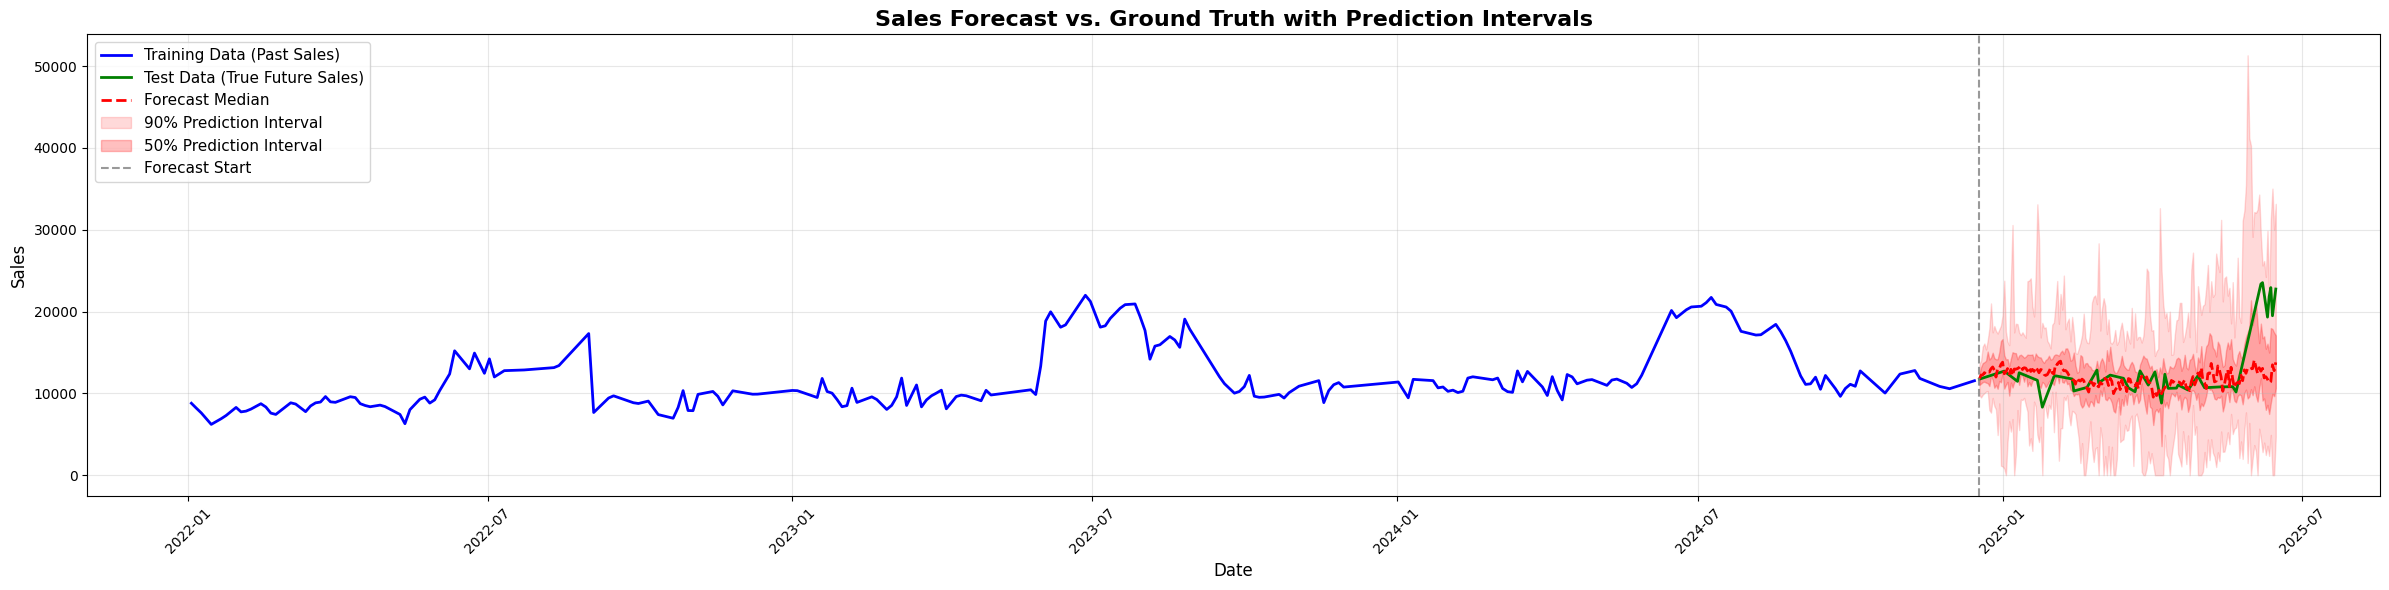

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Generate prediction on test data
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=30  # Speed up
)

forecast = next(forecast_it)
ts = next(ts_it)

# Forecast start date (Period → Timestamp)
forecast_start = forecast.start_date.to_timestamp()

# Forecast date range
forecast_dates = pd.date_range(
    start=forecast_start,
    periods=forecast.prediction_length,
    freq=forecast.freq
)

# --- Slice original df1 for Train + Test comparison ---
train_window = df1[df1['date'] < forecast_start]
test_window = df1[(df1['date'] >= forecast_start) & (df1['date'] < forecast_start + pd.Timedelta(days=forecast.prediction_length))]

# Downsample training data for faster plotting
plot_train = train_window.iloc[::3]  # every 3rd point

# --- Plot ---
fig, ax = plt.subplots(figsize=(24, 6))

# 🔵 Plot historical training sales
ax.plot(
    plot_train['date'],
    plot_train['sales'],
    label='Training Data (Past Sales)',
    color='blue',
    linewidth=2
)

# 🟢 Plot test/ground truth future sales
ax.plot(
    test_window['date'],
    test_window['sales'],
    label='Test Data (True Future Sales)',
    color='green',
    linewidth=2
)

# 🔴 Forecast median
ax.plot(
    forecast_dates,
    forecast.median,
    label='Forecast Median',
    color='red',
    linewidth=2,
    linestyle='--'
)

# 🔴🔴 Prediction Intervals

# 90% CI
ax.fill_between(
    forecast_dates,
    forecast.quantile(0.05),
    forecast.quantile(0.95),
    color='red',
    alpha=0.15,
    label='90% Prediction Interval'
)

# 50% CI
ax.fill_between(
    forecast_dates,
    forecast.quantile(0.25),
    forecast.quantile(0.75),
    color='red',
    alpha=0.25,
    label='50% Prediction Interval'
)

# Forecast start line
ax.axvline(forecast_start, color='gray', linestyle='--', alpha=0.8, label='Forecast Start')

# Labels & Styling
ax.set_title("Sales Forecast vs. Ground Truth with Prediction Intervals", fontsize=16, weight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Sales", fontsize=12)
ax.legend(fontsize=11, loc='upper left')
plt.xticks(rotation=45)
ax.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("6monthforecast/sales_forecast_plot_time_no_yoy_noMonthCumsum_spline_1.png", dpi=300)
plt.show()


# Auto-ARIMA

In [28]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from pmdarima import auto_arima
# import warnings

# # --- Optional: Suppress FutureWarnings ---
# warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# # --- Step 1: Preprocess your DataFrame ---
# # Make sure your df1 has a datetime index
# df1['date'] = pd.to_datetime(df1['date'])
# df1 = df1.set_index('date')
# df1 = df1.asfreq('D')  # Daily frequency
# # df1['sales'] = df1['sales'].interpolate()  # Fill missing values if any

# # --- Step 2: Train/Test Split ---
# train = df1.iloc[:1170]
# test = df1.iloc[1170:]  # Should be 90 rows

# # --- Step 3: Fit Auto ARIMA on Training Data ---
# # model = auto_arima(train['sales'], seasonal=True, stepwise=True, trace=True, suppress_warnings=True)
# model = auto_arima(train['sales'], 
#                    seasonal=True,
#                    m=183,  # if weekly seasonality, change to 12/monthly or 365/yearly
#                    stepwise=True, 
#                    trace=True,
#                    suppress_warnings=True)

# # --- Step 4: Forecast next 90 days ---
# n_periods = len(test)
# forecast = model.predict(n_periods=n_periods)
# forecast_index = test.index

# # --- Step 5: Create forecast DataFrame ---
# forecast_df = pd.DataFrame({
#     "date": forecast_index,
#     "forecast_units_sold": forecast
# }).set_index("date")

# # --- Step 6: Plot Historical, Test, and Forecast ---
# plt.figure(figsize=(14, 6))
# plt.plot(train.index, train['sales'], label="Training Data", color='blue')
# plt.plot(test.index, test['sales'], label="Actual Test Data", color='green')
# plt.plot(forecast_df.index, forecast_df['forecast_units_sold'], label="Forecast", color='orange', linestyle='--')

# plt.title("Auto ARIMA Forecast vs Actual")
# plt.xlabel("Date")
# plt.ylabel("Units Sold")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- Step 7: Show Forecast DataFrame ---
# # print(forecast_df.head())
